In [1]:
import numpy as np

def pq_curve(q, q_min=10.0, q_max=30.0, q_out=40.0, p_min=1000.0, p_max=5000.0, seed=None):
    rng = np.random.default_rng(seed=seed)
    q = q + rng.normal(0.0, 1.0)
    if q <= q_min:
        p = 0
    elif q >= q_out:
        p = 0
    else:
        a = (p_max - p_min) / (q_max - q_min)
        p = min(p_max, a*(q - q_min) + p_min)
        e = min(0, rng.normal(0.0, 200.0))
        p = p + e
    return p

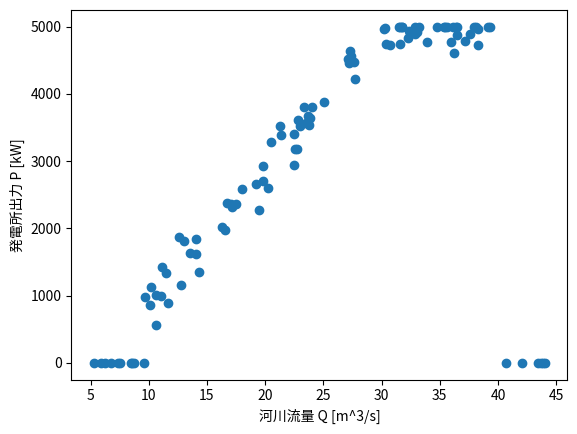

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=42)
X = rng.uniform(5.0, 45.0, size=100)
y = np.array([pq_curve(x, seed=rng.integers(1, 9999)) for x in X])
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.scatter(X, y)
plt.xlabel("河川流量 Q [m^3/s]")
plt.ylabel("発電所出力 P [kW]")
plt.show()

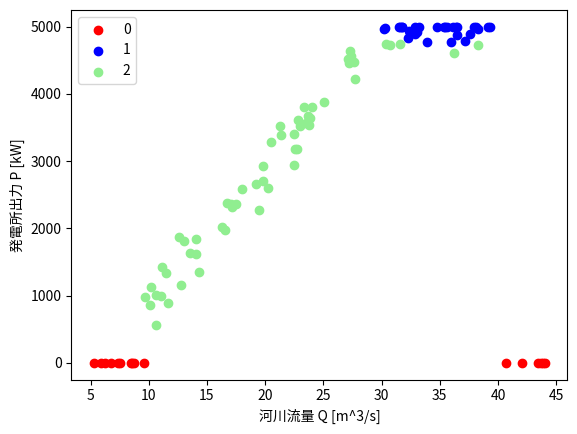

In [3]:
def labeling(p_data, p_upper=4750.0):
    labels = []
    for p in p_data.flatten():
        if p == 0:
            labels.append(0)
        elif p >= p_upper:
            labels.append(1)
        else:
            labels.append(2)
    return np.array(labels)

cls = labeling(y)

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
for idx, seg in enumerate(np.unique(cls)):
    plt.scatter(x=X[cls == seg], y=y[cls == seg], c=colors[idx], label=seg)
plt.xlabel("河川流量 Q [m^3/s]")
plt.ylabel("発電所出力 P [kW]")
plt.legend(loc='upper left')
plt.show()

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions1(X, y, cls, classifier, test_idx=None, resolution=0.02):
    markers = ('s', '^', 'o', 'v', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(cls))])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = y[:].min() - 1, y[:].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                           np.arange(y_min, y_max, resolution))
    Z = classifier.predict(np.array([xx.ravel()]).T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    for idx, cl in enumerate(np.unique(cls)):
        plt.scatter(x=X[cls == cl, 0], y=y[cls == cl], alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolors='black')
    if test_idx:
        X_test, y_test = X[test_idx], y[test_idx]
        plt.scatter(X_test[:, 0], y_test[:], c='none', edgecolors='black',
                    alpha=1.0, linewidths=1, marker='o', s=100, label='test set')

In [5]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()


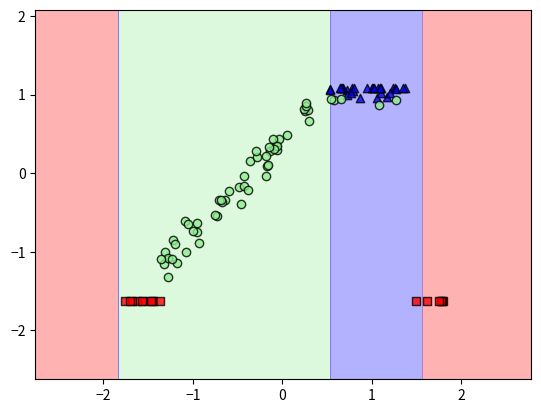

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_std, cls)

plot_decision_regions1(X=X_std, y=y_std, cls=cls, classifier=clf, resolution=0.02)
plt.show()

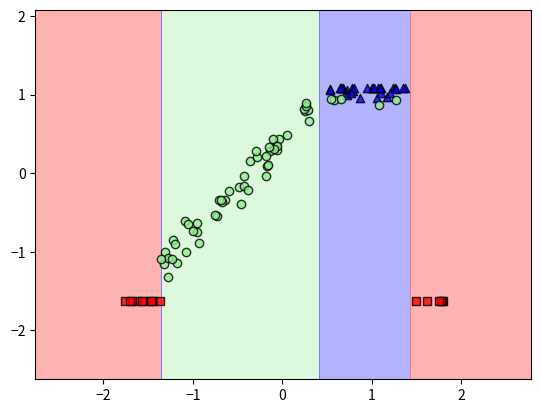

In [7]:
from sklearn import tree

clf2 = tree.DecisionTreeClassifier(max_depth=2)
clf2.fit(X_std, cls)

plot_decision_regions1(X=X_std, y=y_std, cls=cls, classifier=clf2, resolution=0.02)
plt.show()

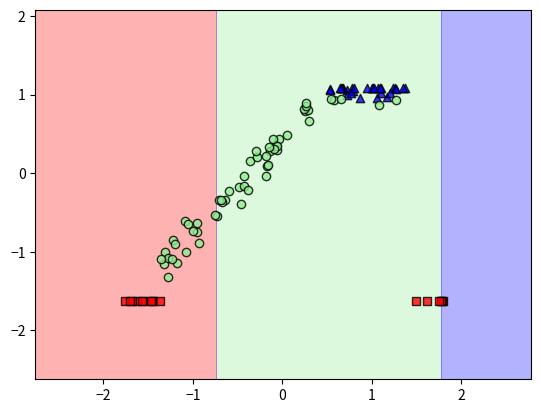

In [8]:
from sklearn.linear_model import SGDClassifier

clf3 = SGDClassifier(
    loss="log_loss", 
    penalty="l2", 
    alpha=0.0001, 
    max_iter=10000,
    random_state=1
)
clf3.fit(X_std, cls)

plot_decision_regions1(X=X_std, y=y_std, cls=cls, classifier=clf3)
plt.show()

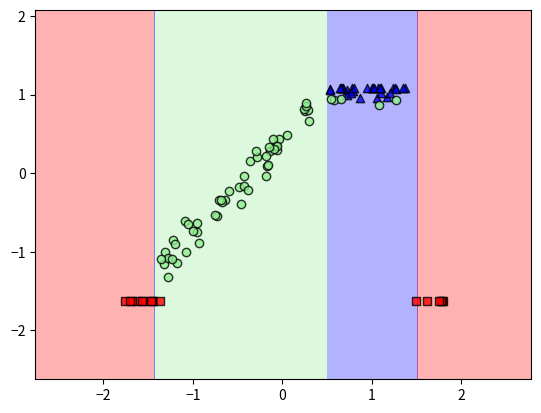

In [9]:
from sklearn import svm

clf4 = svm.SVC(kernel='rbf', gamma='auto')
clf4.fit(X_std, cls)

plot_decision_regions1(X=X_std, y=y_std, cls=cls, classifier=clf4)
plt.show()

## 回帰
- 分類番号２（緑）のデータを回帰する。
- 分類器は決定木を使用した。
- 次の回帰モデルを当てはめて結果を比較する。
 1. 単回帰
 2. Lasso回帰
 3. SDG回帰
 4. ARD回帰
 5. ガウス過程

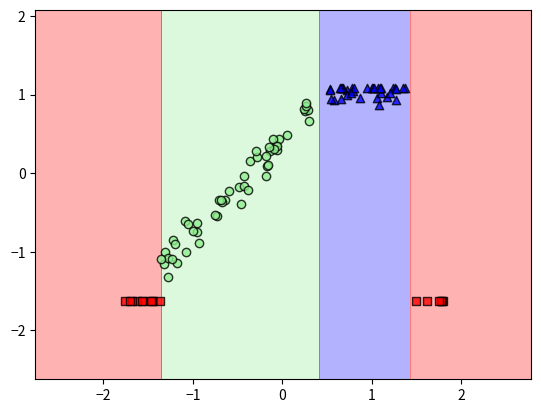

In [10]:
cls2 = clf2.predict(X_std)

plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
plt.show()

coef: 1.196
intercept: 0.436


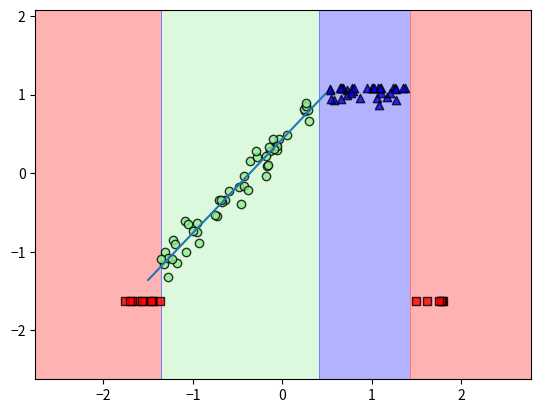

In [11]:
from sklearn.linear_model import LinearRegression

rg = LinearRegression()
rg.fit(X_std[cls2 == 2], y_std[cls2 == 2])
print("coef: %.3f" % rg.coef_[0])
print("intercept: %.3f" % rg.intercept_)

X_pred = np.arange(-1.5, 0.5, 0.02)[:, np.newaxis]
plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
plt.plot(X_pred, rg.predict(X_pred))
plt.show()

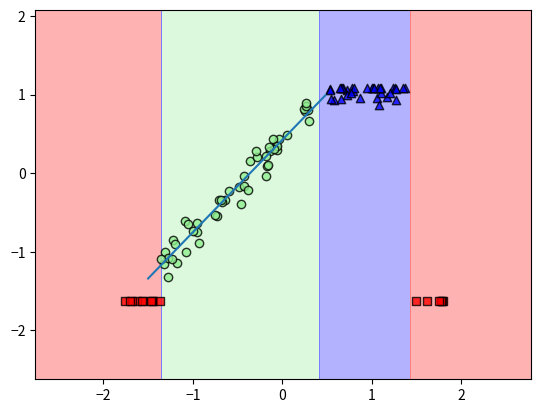

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

rg2 = make_pipeline(
    PolynomialFeatures(degree=10),
    StandardScaler(),
    Lasso(alpha=0.01,random_state=1)
)

rg2.fit(X_std[cls2 == 2], y_std[cls2 == 2])
y_lasso = rg2.predict(X_pred)

plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
plt.plot(X_pred, y_lasso)
plt.show()

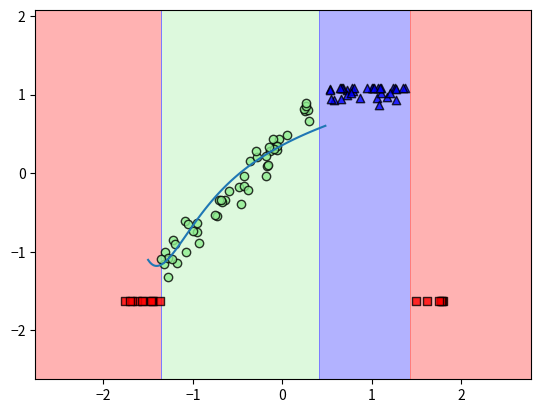

In [13]:
from sklearn.linear_model import SGDRegressor

rg3 = make_pipeline(
    PolynomialFeatures(degree=10),
    StandardScaler(),
    SGDRegressor(
        loss='squared_error',
        penalty='l2',
        alpha=0.01,
        random_state=1
    )
)

rg3.fit(X_std[cls2 == 2], y_std[cls2 == 2])
y_sdgr = rg3.predict(X_pred)

plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
plt.plot(X_pred, y_sdgr)
plt.show()


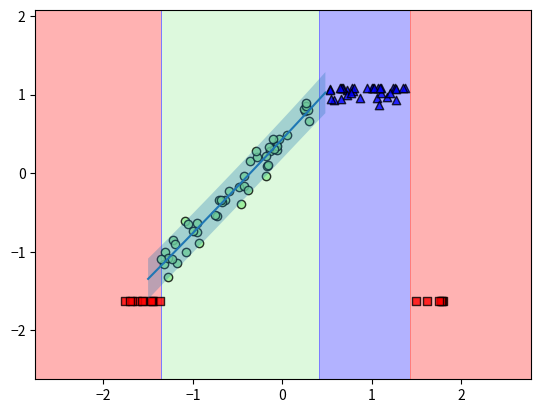

In [14]:
from sklearn.linear_model import ARDRegression

rg4 = make_pipeline(
    PolynomialFeatures(degree=10),
    StandardScaler(),
    ARDRegression()
)

rg4.fit(X_std[cls2 == 2], y_std[cls2 == 2])
y_ard, y_ard_std = rg4.predict(X_pred, return_std=True)

plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
plt.plot(X_pred, y_ard)
plt.fill_between(
    x=X_pred.flatten(), 
    y1=y_ard + 2.0*y_ard_std,
    y2=y_ard - 2.0*y_ard_std,
    alpha=0.3
)
plt.show()

2.36**2 * RBF(length_scale=3.14) + WhiteKernel(noise_level=0.0154)


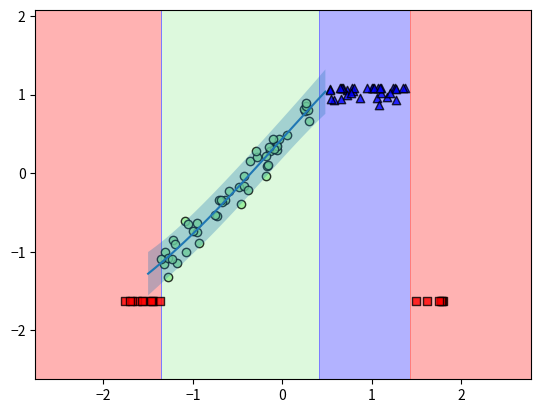

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e+3)) + WhiteKernel() 
rg5 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
rg5.fit(X_std[cls2 == 2], y_std[cls2 == 2])
print(rg5.kernel_)

plot_decision_regions1(X=X_std, y=y_std, cls=cls2, classifier=clf2)
y_gp, y_gp_std = rg5.predict(X_pred, return_std=True)
plt.plot(X_pred, y_gp)
plt.fill_between(
    x=X_pred.flatten(), 
    y1=y_gp + 2.0*y_gp_std,
    y2=y_gp - 2.0*y_gp_std,
    alpha=0.3
)
plt.show()

## ここからレポート用コードと画像出力

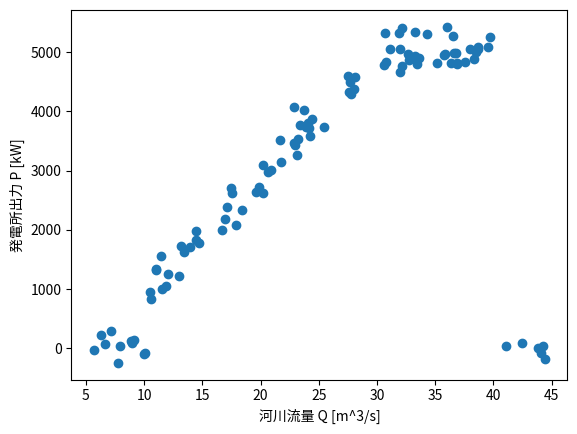

In [32]:
# サンプルデータを生成
# 河川流量に対し発電所出力が比例する仮定
# 引き戻し回路と取水停止を考慮
# 河川流量および発電所出力に誤差を設定

import numpy as np
import matplotlib.pyplot as plt

def pq_curve2(q, q_min=10.0, q_max=30.0, q_out=40.0, p_min=1000.0, p_max=5000.0, seed=None):
    if q <= q_min:
        p = 0
    elif q >= q_out:
        p = 0
    else:
        a = (p_max - p_min) / (q_max - q_min)
        p = min(p_max, a*(q - q_min) + p_min)
        e = min(0, rng.normal(0.0, 200.0))
        p = p + e
    return p

rng = np.random.default_rng(seed=42)
Q = rng.uniform(5.0, 45.0, size=100)
X = Q + rng.normal(0.0, 1.0)
y = np.array([pq_curve2(q, seed=rng.integers(1, 999)) for q in Q])
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
plt.rcParams['font.family'] = "Noto Sans CJK JP"
plt.scatter(X, y)
plt.xlabel("河川流量 Q [m^3/s]")
plt.ylabel("発電所出力 P [kW]")
plt.show()

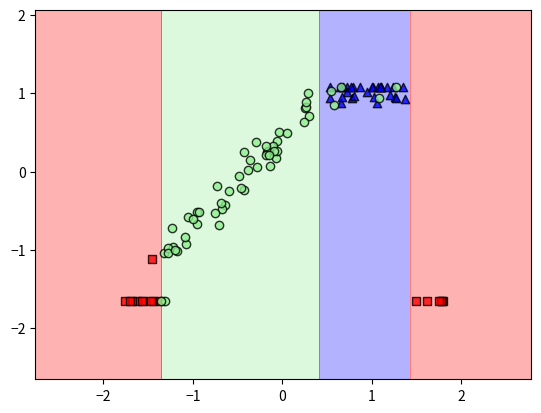

In [30]:
# 決定木モデルを使い、運転範囲を3つに分類
# class0: 運転可能範囲外
# class1: 部分負荷運転範囲
# class2: 最大負荷運転範囲

from sklearn.preprocessing import StandardScaler
from sklearn import tree

# サンプルデータを平均0・分散1に標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()


clf2 = tree.DecisionTreeClassifier(max_depth=2)
clf2.fit(X_std, cls)

plot_decision_regions1(X=X_std, y=y_std, cls=cls, classifier=clf2, resolution=0.02)
plt.show()